In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import numpy as np
import keras
from keras_preprocessing import image
from PIL import Image
import cv2


def random_flip(img, mask, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
        mask = image.flip_axis(mask, 1)
    if np.random.random() < u:
        img = image.flip_axis(img, 0)
        mask = image.flip_axis(mask, 0)
    return img, mask

def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = image.apply_affine_transform(img, theta=theta)
        mask = image.apply_affine_transform(mask, theta=theta)
    return img, mask

def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    x = image.apply_affine_transform(x, ty=ty, tx=tx)
    return x

def random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
        mask = shift(mask, wshift, hshift)
    return img, mask

def random_zoom(img, mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = image.apply_affine_transform(img, zx=zx, zy=zy)
        mask = image.apply_affine_transform(mask, zx=zx, zy=zy)
    return img, mask



def random_shear(img, mask, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = image.apply_affine_transform(img, shear=sh)
        mask = image.apply_affine_transform(mask, shear=sh)
    return img, mask

def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def random_crop(img, mask, u=0.1):
    if np.random.random() < u:
        w, h = img.shape[0], img.shape[1]
        offsetw = np.random.randint(w//2)
        offseth = np.random.randint(w//2)

        endw = np.random.randint(w // 2)+w // 2
        endh = np.random.randint(w // 2)+w // 2

        new_im = img[offsetw:offsetw + endw, offseth:offseth + endh, :]
        new_mask = mask[offsetw:offsetw + endw, offseth:offseth + endh, :]

        new_im, new_mask = cv2.resize(new_im, interpolation = cv2.INTER_LINEAR, dsize=(w, h)), \
               cv2.resize(new_mask, interpolation=cv2.INTER_LINEAR, dsize=(w, h))

        new_mask = new_mask[..., np.newaxis]
        return new_im, new_mask
    else:
        return img, mask


def random_augmentation(img, mask):
    img = random_brightness(img, limit=(-0.1, 0.1), u=0.05)
    img = random_contrast(img, limit=(-0.1, 0.1), u=0.05)
    img = random_saturation(img, limit=(-0.1, 0.1), u=0.05)
    img, mask = random_rotate(img, mask, rotate_limit=(-10, 10), u=0.05)
    img, mask = random_shear(img, mask, intensity_range=(-5, 5), u=0.05)
    img, mask = random_flip(img, mask, u=0.5)
    img, mask = random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.05)
    img, mask = random_zoom(img, mask, zoom_range=(0.9, 1.1), u=0.05)
    return img, mask

Using TensorFlow backend.


In [2]:
import argparse
from glob import glob

import numpy as np
from PIL import Image
from keras import layers
from keras import backend as K
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, MaxPooling2D
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, ReLU
from keras.models import Model
from keras.optimizers import Adam
from numpy import random
import tensorflow as tf
#from aug_utils import random_augmentation
from random import randint


batch_size = 16
input_shape = (64, 64)


def custom_activation(x):
    return K.relu(x, alpha=0.0, max_value=1)


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

smooth = 1.


cardinality = 32



def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y
      
      
      


def get_unet(do=0, activation=ReLU):
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    conv1= add_common_layers(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1= residual_block(pool1,32,32, _project_shortcut=False)

  

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    conv2= add_common_layers(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2= residual_block(pool2,64,64, _project_shortcut=False)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    conv3= add_common_layers(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3= residual_block(pool3,128,128, _project_shortcut=False)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    conv4= add_common_layers(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4= residual_block(pool4,256,256, _project_shortcut=False)


    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))
    conv5= add_common_layers(conv5)
    conv5= residual_block(conv5,512,512, _project_shortcut=False)
    

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    up6= add_common_layers(up6)
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))
    conv6= residual_block(conv6,256,256, _project_shortcut=False)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    up7= add_common_layers(up7)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))
    conv7= residual_block(conv7,128,128, _project_shortcut=False)


    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    up8= add_common_layers(up8)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))
    conv8= residual_block(conv8,64,64, _project_shortcut=False)


    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    up9 = add_common_layers(up9)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))
    conv9= residual_block(conv9,32,32, _project_shortcut=False)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss=losses.binary_crossentropy, metrics=['accuracy'])


    return model


def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))/255.
    return x[..., np.newaxis]


def random_crop(img, mask, crop_size=input_shape[0]):
    imgheight= img.shape[0]
    imgwidth = img.shape[1]
    i = randint(0, imgheight-crop_size)
    j = randint(0, imgwidth-crop_size)

    return img[i:(i+crop_size), j:(j+crop_size), :], mask[i:(i+crop_size), j:(j+crop_size)]


def gen(data, au=False):
    while True:
        repeat = 4
        index= random.choice(list(range(len(data))), batch_size//repeat)
        index = list(map(int, index))
        list_images_base = [read_input(data[i][0]) for i in index]
        list_gt_base = [read_gt(data[i][1]) for i in index]

        list_images = []
        list_gt = []

        for image, gt in zip(list_images_base, list_gt_base):

            for _ in range(repeat):
                image_, gt_ = random_crop(image.copy(), gt.copy())
                list_images.append(image_)
                list_gt.append(gt_)

        list_images_aug = []
        list_gt_aug = []

        for image, gt in zip(list_images, list_gt):
            if au:
                image, gt = random_augmentation(image, gt)
            list_images_aug.append(image)
            list_gt_aug.append(gt)

        yield np.array(list_images_aug), np.array(list_gt_aug)


if __name__ == '__main__':

    #ap = argparse.ArgumentParser()
    #ap.add_argument("-d", "--dropout", required=False,
     #               help="dropout", type=float, default=0.1)
    #ap.add_argument("-a", "--activation", required=False,
                 #   help="activation", default="ReLU")

   # args = parser.parse_args(argv[1:])
    #args = easydict.EasyDict({
    #"dropout": 0.1,
    #"activation":ReLU
#})

    activation = ReLU

    model_name = "baseline_unet_do_%s_activation_%s_"%(0.1,ReLU)

    print("Model : %s"%model_name)

    train_data = list(zip(sorted(glob('drive/My Drive/DRIVE/training/images/*.tif')),
                          sorted(glob('drive/My Drive/DRIVE/training/1st_manual/*.gif'))))

    model = get_unet(do=0.1, activation=activation)

    file_path = model_name + "weights.best.hdf5"
    try:
        model.load_weights(file_path, by_name=True)
    except:
        pass




    history = model.fit_generator(gen(train_data, au=True), epochs=5, verbose=2,
                         steps_per_epoch= 100*len(train_data)//batch_size,
                                  use_multiprocessing=True, workers=16)

    model.save_weights(file_path)

W0701 06:05:48.598486 140346192439168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 06:05:48.612648 140346192439168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 06:05:48.616452 140346192439168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 06:05:48.631737 140346192439168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0701 06:05:48.640536 

Model : baseline_unet_do_0.1_activation_<class 'keras.layers.advanced_activations.ReLU'>_


W0701 06:05:49.497248 140346192439168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0701 06:05:49.558405 140346192439168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0701 06:05:57.827400 140346192439168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0701 06:05:57.838527 140346192439168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for u

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 62s - loss: 0.2879 - acc: 0.8908
Epoch 2/5
 - 29s - loss: 0.1541 - acc: 0.9370
Epoch 3/5
 - 29s - loss: 0.1310 - acc: 0.9428
Epoch 4/5
 - 29s - loss: 0.1353 - acc: 0.9392
Epoch 5/5
 - 29s - loss: 0.1265 - acc: 0.9436


In [3]:
import h5py
from glob import glob
from PIL import Image
from skimage.transform import resize
import numpy as np
from matplotlib import pyplot as plt
from skimage.morphology import label
from pycocotools import mask as maskUtils
from tqdm import tqdm
import os
import cv2
from keras.layers import ReLU
from sklearn.metrics import roc_auc_score

batchsize = 4
input_shape = (576, 576)


def batch(iterable, n=batchsize):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))
    return x[..., np.newaxis]/np.max(x)

if __name__ == '__main__':
    model_name = "baseline_unet_aug_do_0.1_activation_ReLU_"


    val_data = list(zip(sorted(glob('drive/My Drive/DRIVE/test/images/*.tif')),
                        sorted(glob('drive/My Drive/DRIVE/test/2nd_manual/*.gif')), 
                        sorted(glob('drive/My Drive/DRIVE/test/mask/*.gif'))))

    try:
        os.makedirs("../output/"+model_name+"test/", exist_ok=True)
    except:
        pass

    model = get_unet(do=0.1, activation=ReLU)

    file_path = model_name + "weights.best.hdf5"

    try :
      model.load_weights(file_path,by_name=True)
    except :
      pass
    
    
    
    gt_list = []
    pred_list = []

    for batch_files in tqdm(batch(val_data), total=len(val_data)//batchsize):

        imgs = [resize(read_input(image_path[0]), input_shape) for image_path in batch_files]
        seg = [read_gt(image_path[1]) for image_path in batch_files]
        mask = [read_gt(image_path[2]) for image_path in batch_files]

        imgs = np.array(imgs)

        pred = model.predict(imgs)

        pred_all = (pred)

        pred = np.clip(pred, 0, 1)

        for i, image_path in enumerate(batch_files):

            pred_ = pred[i, :, :, 0]

            pred_ = resize(pred_, (584, 565))

            mask_ = mask[i]

            gt_ = (seg[i]>0.5).astype(int)
        

            gt_flat = []
            pred_flat = []

            for p in range(pred_.shape[0]):
                for q in range(pred_.shape[1]):
                    if  (mask_[p,q].any()> 0.5): # Inside the mask pixels only
                        gt_flat.append(gt_[p,q])
                        pred_flat.append(pred_[p,q])

            print(pred_.size, len(gt_list))

            gt_list += gt_flat
            pred_list += pred_flat

            pred_ = 255.*(pred_ - np.min(pred_))/(np.max(pred_)-np.min(pred_))

            image_base = image_path[0].split("/")[-1]

            cv2.imwrite("../output/"+model_name+"test/"+image_base, pred_)

    print(len(gt_list), len(pred_list))
    print("AUC ROC : " ,roc_auc_score(gt_list,pred_list))

  0%|          | 0/5 [00:00<?, ?it/s]

329960 0
329960 224377
329960 449464


 20%|██        | 1/5 [00:17<01:10, 17.59s/it]

329960 675191
329960 902768
329960 1130461
329960 1357960


 40%|████      | 2/5 [00:23<00:42, 14.04s/it]

329960 1585635
329960 1810883
329960 2038543
329960 2265875


 60%|██████    | 3/5 [00:29<00:23, 11.56s/it]

329960 2493689
329960 2721294
329960 2948794
329960 3174648


 80%|████████  | 4/5 [00:34<00:09,  9.84s/it]

329960 3402042
329960 3629736
329960 3855620
329960 4083232


100%|██████████| 5/5 [00:40<00:00,  8.62s/it]

329960 4310620
4538143 4538143


AUC ROC :  0.4792137150497268


In [0]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(gt_list, pred_list, 'b', label = 'AUC = %0.2f' % roc_auc_score(gt_list,pred_list))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(64, 64, 3) (64, 64) [[[0.5046242 ]
  [0.505296  ]
  [0.50508785]
  ...
  [0.50612885]
  [0.5050676 ]
  [0.50586593]]

 [[0.5061732 ]
  [0.5060559 ]
  [0.506479  ]
  ...
  [0.50652033]
  [0.5070218 ]
  [0.50652504]]

 [[0.5048917 ]
  [0.505389  ]
  [0.504892  ]
  ...
  [0.5061195 ]
  [0.5053183 ]
  [0.50627637]]

 ...

 [[0.50679183]
  [0.5065747 ]
  [0.5067111 ]
  ...
  [0.5057431 ]
  [0.5061435 ]
  [0.5059844 ]]

 [[0.5057067 ]
  [0.50639397]
  [0.50544846]
  ...
  [0.50572395]
  [0.50473243]
  [0.5057923 ]]

 [[0.50724   ]
  [0.5068681 ]
  [0.50684524]
  ...
  [0.5058727 ]
  [0.5060875 ]
  [0.50601286]]]


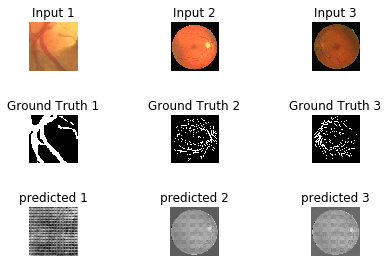

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
#from aug_utils import random_augmentation
from random import randint


def plot_figures(names, figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.
    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(names):
        img = np.squeeze(figures[title])
        if len(img.shape)==2:
            axeslist.ravel()[ind].imshow(img, cmap=plt.gray())#, cmap=plt.gray()
        else:
            axeslist.ravel()[ind].imshow(img)


        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

    plt.show()


def read_input(path):
    x = Image.open(path)
    return np.array(x)/255.


def read_gt(path):
    y = Image.open(path)
    return np.array(y)/255.


def random_crop(img, mask,pred, crop_size=64):
    imgheight= img.shape[0]
    imgwidth = img.shape[1]
    i = randint(0, imgheight-crop_size)
    j = randint(0, imgwidth-crop_size)

    return img[i:(i+crop_size), j:(j+crop_size), :], mask[i:(i+crop_size), j:(j+crop_size)] ,pred[i:(i+crop_size), j:(j+crop_size)] 

figures = {}
gt_1 = read_gt('gdrive/My Drive/DRIVE/test/1st_manual/01_manual1.gif')
img_1 = read_gt('gdrive/My Drive/DRIVE/test/images/01_test.tif')
pred_1 = (pred[0])
img_1, gt_1,pred_1 = random_crop(img_1, gt_1,pred_1, crop_size = 64)
print(img_1.shape, gt_1.shape, pred_1)
figures['Input 1'] = img_1
figures['Ground Truth 1'] = gt_1
figures['predicted 1'] = pred_1

gt_2 = read_gt('gdrive/My Drive/DRIVE/test/1st_manual/02_manual1.gif')
img_2 = read_gt('gdrive/My Drive/DRIVE/test/images/02_test.tif')
pred_2 = (pred[1])
figures['Input 2'] = img_2
figures['Ground Truth 2'] = gt_2
figures['predicted 2'] = pred_2

gt_3 = read_gt('gdrive/My Drive/DRIVE/test/1st_manual/03_manual1.gif')
img_3 = read_gt('gdrive/My Drive/DRIVE/test/images/03_test.tif')
pred_3 = (pred[2])
figures['Input 3'] = img_3
figures['Ground Truth 3'] = gt_3
figures['predicted 3'] = pred_3
#print(gt_3.shape)



# generation of a dictionary of (title, images)
names = ['Input 1', 'Input 2', 'Input 3', 'Ground Truth 1', 'Ground Truth 2', 'Ground Truth 3','predicted 1','predicted 2','predicted 3']

# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(names, figures, 3,3)